<a href="https://www.kaggle.com/code/khushaljainn/23-fake-image?scriptVersionId=111410738" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Library

In [1]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import os

In [2]:
print(os.listdir("../input"))

['real-and-fake-face-detection']


In [3]:
real = "../input/real-and-fake-face-detection/real_and_fake_face/training_real/"
fake = "../input/real-and-fake-face-detection/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

## Visulaizing the real and fake faces

In [4]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

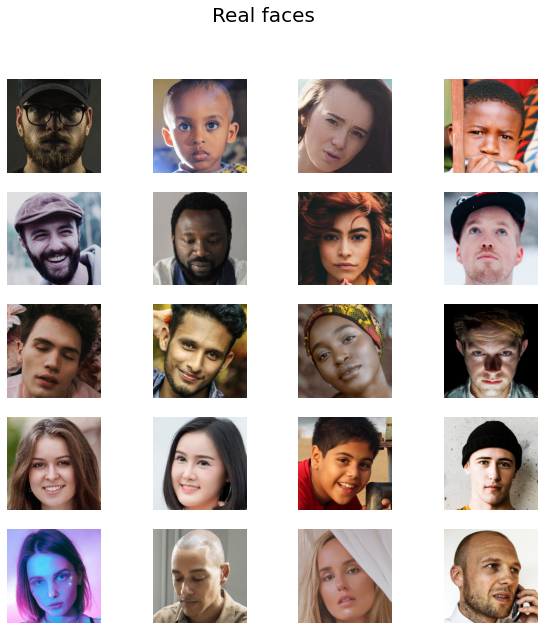

In [5]:
fig = plt.figure(figsize=(10, 10))
#10x10px m image plot hogi for visual purposes
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')
plt.show()

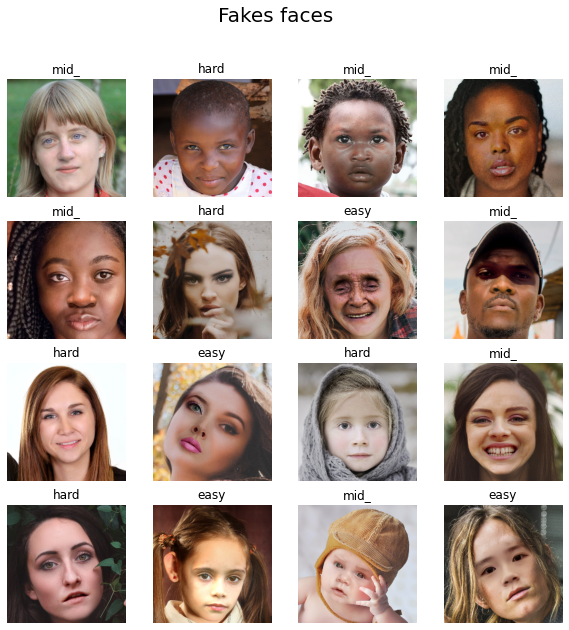

In [6]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

In [7]:
dataset_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face"

## Data augumentation: Keras

Yahan dataset ka size increase hoga, existing data se modified dataset banega

In [8]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   #Row col interchange
                                   vertical_flip=False,
                                   rescale=1./255, 
#rescaling kyuki RGB ki values 0-255 hoti h which is very big for model so 0-1 ke beech m krne k liye 1/255
                                  validation_split=0.2)
#If you don't, your results will be biased, and you'll end up with a false impression of better model accuracy

In [9]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 1633 images belonging to 2 classes.


In [10]:
#Augumented data ke batches banke value will be replaced by augumented data for model training
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 408 images belonging to 2 classes.


# # # ## **MobileNetV2**

In [11]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## Callbacks

In [13]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [14]:
hist = model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

Epoch 1/20
52/52 [==============================] - 34s 648ms/step - loss: 0.8696 - accuracy: 0.6044 - val_loss: 1.4698 - val_accuracy: 0.5025
Epoch 2/20
52/52 [==============================] - 21s 403ms/step - loss: 0.5920 - accuracy: 0.7146 - val_loss: 0.9047 - val_accuracy: 0.5319
Epoch 3/20
52/52 [==============================] - 21s 400ms/step - loss: 0.4510 - accuracy: 0.7869 - val_loss: 1.0088 - val_accuracy: 0.5245
Epoch 4/20
52/52 [==============================] - 20s 390ms/step - loss: 0.3771 - accuracy: 0.8194 - val_loss: 0.9314 - val_accuracy: 0.5172
Epoch 5/20
52/52 [==============================] - 21s 399ms/step - loss: 0.3237 - accuracy: 0.8714 - val_loss: 0.9864 - val_accuracy: 0.5025
Epoch 6/20
52/52 [==============================] - 21s 399ms/step - loss: 0.3011 - accuracy: 0.8751 - val_loss: 1.0042 - val_accuracy: 0.5098
Epoch 7/20
52/52 [==============================] - 20s 387ms/step - loss: 0.3007 - accuracy: 0.8751 - val_loss: 1.0141 - val_accuracy: 0.5343

## Visualising the accuracy and loss

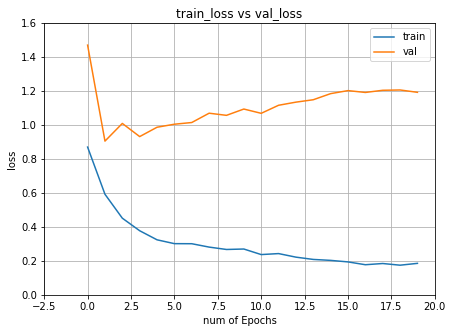

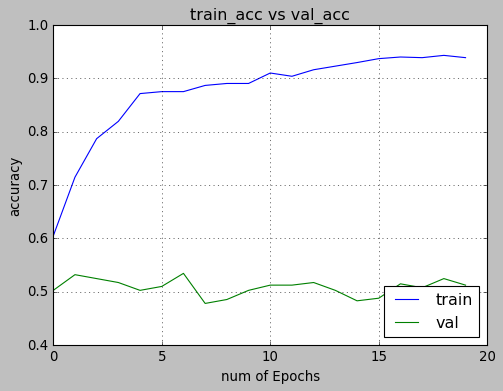

In [15]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

## Trying VGG16 model

In [16]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [17]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
vgg16_model.output[-1]

<tf.Tensor 'strided_slice:0' shape=(7, 7, 512) dtype=float32>

In [19]:
# model = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model.add(layer)

# for layer in model.layers:
#     layer.trainable = False
    
# model.add(Dense(2, activation='softmax'))


model = Sequential([vgg16_model,
                    Flatten(),
#                     GlobalAveragePooling2D(),
#                     Dense(512, activation = "relu"),
#                     BatchNormalization(),
#                     Dropout(0.3),
#                     Dense(128, activation = "relu"),
#                     Dropout(0.1),
#                     # Dense(32, activation = "relu"),
#                     # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
hist =  model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

Epoch 1/20
17/17 [==============================] - 25s 1s/step - loss: 1.2794 - accuracy: 0.5217 - val_loss: 1.1096 - val_accuracy: 0.5343
Epoch 2/20
17/17 [==============================] - 24s 1s/step - loss: 0.6734 - accuracy: 0.6497 - val_loss: 1.0490 - val_accuracy: 0.5294
Epoch 3/20
17/17 [==============================] - 24s 1s/step - loss: 0.5736 - accuracy: 0.7140 - val_loss: 0.9546 - val_accuracy: 0.5441
Epoch 4/20
17/17 [==============================] - 23s 1s/step - loss: 0.4806 - accuracy: 0.7783 - val_loss: 0.8215 - val_accuracy: 0.5588
Epoch 5/20
17/17 [==============================] - 23s 1s/step - loss: 0.4611 - accuracy: 0.7844 - val_loss: 0.8362 - val_accuracy: 0.5711
Epoch 6/20
17/17 [==============================] - 24s 1s/step - loss: 0.4528 - accuracy: 0.7936 - val_loss: 0.8447 - val_accuracy: 0.5490
Epoch 7/20
17/17 [==============================] - 24s 1s/step - loss: 0.4571 - accuracy: 0.7887 - val_loss: 0.8189 - val_accuracy: 0.5833
Epoch 8/20
17/17 [==

## Visualising the accuracy and loss

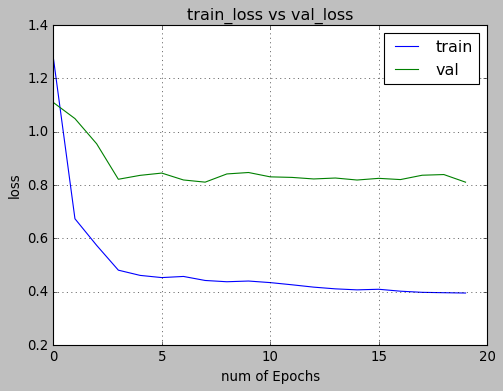

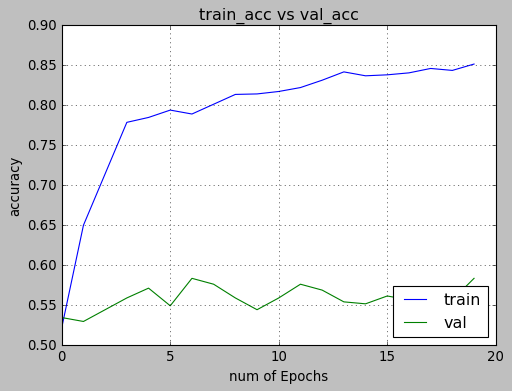

In [21]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

## Predictions

In [22]:
#Creating an array of predicted test images

predictions = model.predict_generator(val)

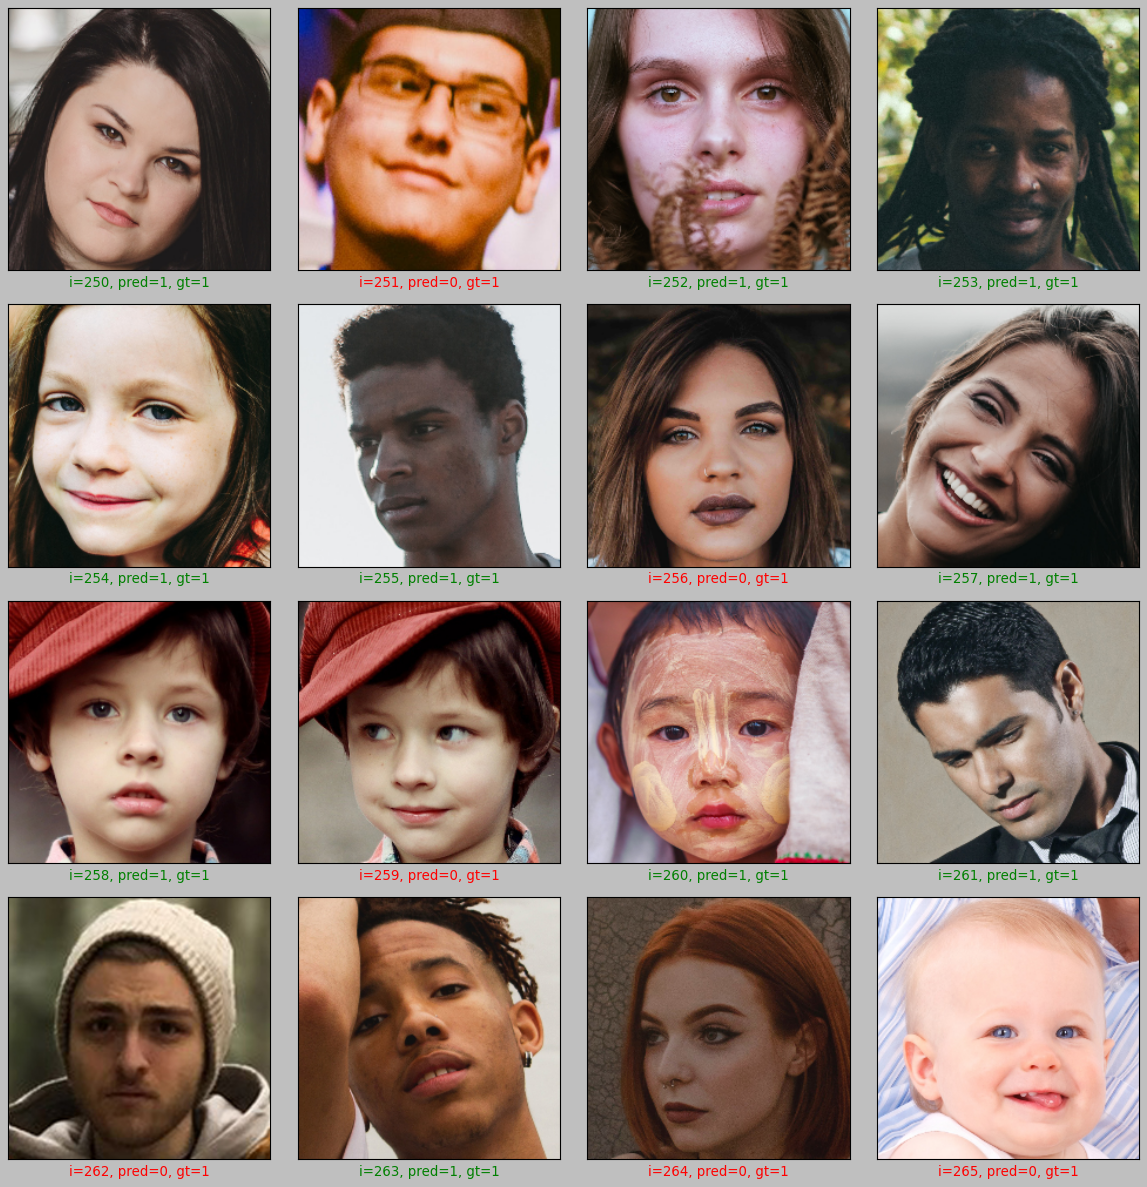

In [23]:
val_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face/"

plt.figure(figsize=(15,15))

start_index = 250

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val.filenames[start_index+i][9:13]

  
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()